# Setup inicial

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict

%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns

from IPython.display import HTML, display
from sklearn import metrics
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import graphviz
from sklearn.tree import export_graphviz

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

import category_encoders as ce

from src.creditapp.data.raw_data_access import get_application_record

# Loading data

In [2]:
df_clients = get_application_record()

df_clients.drop(['id'], axis=1, inplace=True)

print('data loading was successfully...')

data loading was successfully...


<img src="https://av.sc.com/in/content/images/in-credit-card-banner-1600x490px.jpg" />

# Experiments

**Fecha de creación: 13/05/2020**

**Autores: Santiago Porchietto, Agustín Trulli**

El objetivo del presente cuaderno es la realización de multiples experimentos involucrando modelos de Machine Learning en función de determinar cual es el que mejor funciona para esta problemática en particular.

Como se menciona en el análisis anterior, se busca predecir si una persona incurrirá en incumplimiento de sus deudas contraidas mediante tarjeta de crédito. Para esto creamos la columna target (y).

Todas las features que quedaron en el dataset (menos el id) posterior al preprocessing serán utilizadas como entradas (X).

<u>Metricas a utilizar</u>:

* Precission: Para poder determinar que porcentaje de las veces que dijimos positivo acertamos la predicción. Por si sola es insuficiente (Encontramos 2 positivos que realmente lo son (100% de precission), en un dataset que posee 1000 positivos).

* Recall: Para complementar precission, nos va a decir el porcentaje de positivos que encontramos por sobre los reales.

* F1-Score: Como métrica que combina las anteriores.

Con nuestro ejemplo en particular, precission es la métrica que más deberíamos mirar, ya que, en función de las políticas que tome el banco contra los deudores, tendríamos que estar bastante seguros de que una persona lo es antes de etiquetarla de ello.

<u>Modelos a evaluar</u>:

* Decission Tree 

* Random Forest

* Logistic Regression

* K Nearest Neighbors (KNN)

* Gradient Boosted Trees

* Neural Networks

## Feature Engineering 

### Months employed
Armado de los rangos de meses trabajados para "agrupado de valores similares" y reducción de variabilidad.

In [3]:
# parentesis no incluye el término
# corchete incluye el término

# Bajo la suposición de que estas personas nunca trabajaron o se encuentran este periodo de tiempo sin trabajar.
# Se debería consultar con el "cliente/banco", pero tiene sentido.
df_clients["months_employed"].fillna(0, inplace = True)

df_clients.loc[::, 'months_employed_range'] = pd.cut(df_clients.months_employed, 
                                                     list(range(0, 205, 6)), include_lowest='True')

df_clients['months_employed_range'] = df_clients['months_employed_range'].astype(str)
df_clients.loc[df_clients.months_employed_range == 'nan', 'months_employed_range'] = np.nan
df_clients.loc[df_clients.months_employed_range == '(-0.001, 6.0]', 'months_employed_range'] = '[0.0, 6.0]'
df_clients.loc[df_clients.months_employed >= 205, 'months_employed_range'] = '(204.0, 524.0]'

### Income total
Armado de los rangos de ingresos para "agrupado de valores similares" y reducción de variabilidad.

In [4]:
# parentesis no incluye el término
# corchete incluye el término

df_clients.loc[::, 'amt_income_range'] = pd.cut(df_clients.amt_income_total, 
                                               list(range(27000, 300001, 14325)), include_lowest='True')

df_clients['amt_income_range'] = df_clients['amt_income_range'].astype(str)
df_clients.loc[df_clients.amt_income_range == '(26999.999, 41325.0]', 'amt_income_range'] = '[27000.0, 41325.0]'
df_clients.loc[df_clients.amt_income_total > 300000, 'amt_income_range'] = '(300000.0, 1575000.0]'

## Utils

In [5]:
def evaluate_model(model, set_names=('train', 'test'), title=''):
    if title:
        display(title)
    final_metrics = defaultdict(list)
    
    for i, set_name in enumerate(set_names):
        assert set_name in ['train', 'test', 'validation']
        set_data = globals()[set_name] 

        y = set_data.target
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred))

    display(pd.DataFrame(final_metrics, index=set_names))

## Generating test, train & validation sets 

In [6]:
# Test, train & validation sets
train, not_train = train_test_split(df_clients, test_size=0.3, random_state=1)
validation, test = train_test_split(not_train, test_size=0.5, random_state=1)

print('data generating was successfully...')

data generating was successfully...


## Mapper

In [7]:
mapper = DataFrameMapper([
    (['code_gender'], [ce.OneHotEncoder()]),
    (['flag_own_car'], [ce.OneHotEncoder()]),
    (['flag_own_realty'], [ce.OneHotEncoder()]),
    (['cnt_children'], [StandardScaler()]),
    (['name_income_type'], [ce.WOEEncoder()]),
    (['name_education_type'], [ce.WOEEncoder()]),
    (['name_family_status'], [ce.WOEEncoder()]),
    (['name_housing_type'], [ce.WOEEncoder()]),
    (['months_employed_range'], [ce.WOEEncoder()]),
    (['amt_income_range'], [ce.WOEEncoder()]),
    (['occupation_type'], [ce.WOEEncoder()]),
    (['cnt_fam_members'], [StandardScaler()]),
    (['age'], [StandardScaler()]),
    (['flag_mobil'], [ce.OneHotEncoder()]),
    (['flag_work_phone'], [ce.OneHotEncoder()]),
    (['flag_email'], [ce.OneHotEncoder()]),
    (['flag_phone'], [ce.OneHotEncoder()])
])

<u> Los criterios para el armado del mapper fueron los siguientes</u>:

* Se realizó el scaling de los meses trabajados debido a la alta mutabilidad de dicha feature, ajustándola a una distribución con media 0 y desvío estándar 1.

* Para features binarias y categóricas de poca "variabilidad" tales como el género o si la persona posee auto utilizamos OneHotEncoder.

* Para features categóticas con un rango de valores mayor tales como el tipo de ocupación o el tipo de vivienda, utilizamos Weight of Evidence Encoding (WOEE). Este método fue desarrollado principalmente para construir un modelo predictivo para evaluar el riesgo de incumplimiento de préstamos en la industria crediticia y financiera.

Se basa en una medida de cuánto la evidencia apoya o socava una hipótesis. Se calcula en función de:

<img src=https://4.bp.blogspot.com/-X1m0w40w0xg/V9V_7LS1AQI/AAAAAAAAFWc/f4bgPvE1In8Q13kGGBghp98MeWma8KgqACLcB/s1600/woe.png>

<u>Donde</u>:

* Distribution of Goods: Registros que cumplen con el target (pagaron, "buenos clientes").
* Distribution of Bads: Registros que no cumplen con el target (no pagaron, "malos clientes").

<u> Interpretación</u>:

**WOE va a ser 0 si P(GOOD)/P(BAD) = 1 (iguales).**
**WOE va a ser menor a 0 si P(GOOD) < P(BAD) (La razon de probabilidad entre ambas será menor a 1). Menos chances de cumplir.**
**WOE va a ser mayor a 0 si P(GOOD) > P(BAD) (La razon de probabilidad entre ambas será mayor a 1). Mas chances de cumplir.**

<u>Además</u>:

<img src="https://miro.medium.com/max/600/1*9Gi0fGyTpxfwM2TpV4GZQQ.png" width="300" height="50">



<img src=https://miro.medium.com/max/578/1*5S_5aAHWe0_knDGZUK3W8w.png width="300" height="200">

*see more: http://contrib.scikit-learn.org/category_encoders/woe.html*

## Models

### Decission Tree

In [40]:
def get_tree_config():
    params = {
            'max_depth': [6, 7, 8, 9, 10, 11, 12],
            'criterion': ['entropy', 'gini'],
            'class_weight': [{0: 1, 1: 2}, 'balanced']
        }
    
    model = DecisionTreeClassifier(random_state=1)
    
    return model, params

In [41]:
model, parameters = get_tree_config()

grid_search_tree = GridSearchCV(model, parameters, 
                                scoring='f1', verbose=1)

pipe_tree = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=1)),
    ('classifier', grid_search_tree),
])

pipe_tree.fit(train, train.target)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    3.4s finished


Pipeline(memory=None,
         steps=[('mapper',
                 DataFrameMapper(default=False, df_out=False,
                                 features=[(['code_gender'],
                                            [OneHotEncoder(cols=[0],
                                                           drop_invariant=False,
                                                           handle_missing='value',
                                                           handle_unknown='value',
                                                           return_df=True,
                                                           use_cat_names=False,
                                                           verbose=0)]),
                                           (['flag_own_car'],
                                            [OneHotEncoder(cols=[0],
                                                           drop_invariant=False,
                                                           handle_missin

In [42]:
print('Mejor score (f1): ', grid_search_tree.best_score_)
print('Mejores parámetros: ', grid_search_tree.best_params_)

Mejor score (f1):  0.1796879996979423
Mejores parámetros:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6}


In [43]:
evaluate_model(pipe_tree, title='Decision Tree')

'Decision Tree'

,Accuracy,Precision,Recall,F1
train,0.443941,0.112101,0.831193,0.197558
test,0.439746,0.106729,0.786325,0.187947


In [49]:
def graph_tree(tree, col_names):
    graph_data = export_graphviz(
        tree, 
        out_file=None, 
        feature_names=col_names,  
        class_names=['deudor', 'no deudor'],  
        filled=True, 
        rounded=True,  
        special_characters=True,
        max_depth=3,
    )
    graph = graphviz.Source(graph_data)  
    return graph

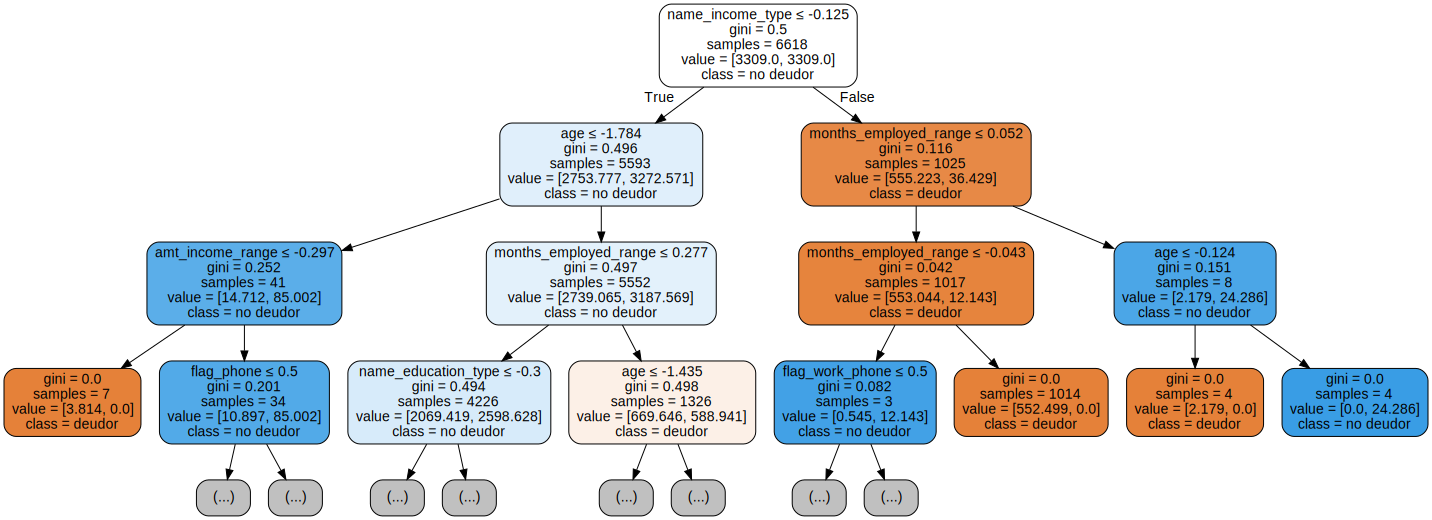

In [50]:
graph_tree(grid_search_tree.best_estimator_, mapper.transformed_names_)

<u>Conclusiones</u>:
* Solo el 10% de las veces que el arbol dijo 1 (deudor) acertó a la predicción.
* No obstante, es capaz de encontrar el 78% de los deudores. Esto nos lleva a penar que el modelo esta clasificando muchas veces como deudor a clientes que, en realidad, no lo son.
* Debido a la amplia diferencia entre estas métricas, la mejor configuración para este modelo nos arroja un F1 de apenas  ≈0.19.

### Random Forests

In [55]:
def get_forest_config():
    params = {
            'n_estimators': [100, 150, 200],
            'max_depth': [8, 9, 10],
            'criterion': ['entropy', 'gini'],
            'class_weight': [{0: 1, 1: 2}, 'balanced'],
            'n_jobs': [-1]
        }
    
    model = RandomForestClassifier(random_state=1)
    
    return model, params

In [56]:
model, parameters = get_forest_config()

grid_search_forest = GridSearchCV(model, parameters, 
                                  scoring='f1', verbose=1)

pipe_forest = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=1)),
    ('classifier', grid_search_forest),
])


pipe_forest.fit(train, train.target)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  2.1min finished


Pipeline(memory=None,
         steps=[('mapper',
                 DataFrameMapper(default=False, df_out=False,
                                 features=[(['code_gender'],
                                            [OneHotEncoder(cols=[0],
                                                           drop_invariant=False,
                                                           handle_missing='value',
                                                           handle_unknown='value',
                                                           return_df=True,
                                                           use_cat_names=False,
                                                           verbose=0)]),
                                           (['flag_own_car'],
                                            [OneHotEncoder(cols=[0],
                                                           drop_invariant=False,
                                                           handle_missin

In [57]:
print('Mejor score (f1): ', grid_search_forest.best_score_)
print('Mejores parámetros: ', grid_search_forest.best_params_)

Mejor score (f1):  0.15870285282781577
Mejores parámetros:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 200, 'n_jobs': -1}


In [58]:
evaluate_model(pipe_forest, title='Random forest')

'Random forest'

,Accuracy,Precision,Recall,F1
train,0.758688,0.243415,0.915596,0.384586
test,0.682875,0.127517,0.487179,0.202128


**Error al imprimir el arbol**

In [19]:
#graph_tree(grid_search_forest.best_estimator_, mapper.transformed_names_)

<u>Conclusiones</u>:
* Solo el ≈13% de las veces que el arbol dijo 1 (deudor) acertó a la predicción.
* En esta ocasión, es capaz de encontrar el ≈49% de los deudores. Esto nos lleva a penar, que a diferencia del decission tree, el forest esta diciendo "esta persona será deudor" en una proporción menor.
* Debido a la diferencia entre estas métricas, la mejor configuración para random forest nos arroja un F1 de apenas  ≈0.20.

### Logistic Regression

In [20]:
def get_logistic_regression_config():
    params = {
            'penalty': ['l1', 'l2', 'elasticnet'],
            'C': [0.1, 1, 0.5],
            'class_weight': [{0: 1, 1: 2}, 'balanced']
        }
    
    model = LogisticRegression(random_state=1)
    
    return model, params

In [21]:
model, parameters = get_logistic_regression_config()

grid_search_logistic_regression = GridSearchCV(model, parameters, 
                                               scoring='f1', verbose=1)

pipe_logistic_regression = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=1)),
    ('classifier', grid_search_logistic_regression),
])


pipe_logistic_regression.fit(train, train.target)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfg

Pipeline(memory=None,
         steps=[('mapper',
                 DataFrameMapper(default=False, df_out=False,
                                 features=[(['code_gender'],
                                            [OneHotEncoder(cols=[0],
                                                           drop_invariant=False,
                                                           handle_missing='value',
                                                           handle_unknown='value',
                                                           return_df=True,
                                                           use_cat_names=False,
                                                           verbose=0)]),
                                           (['flag_own_car'],
                                            [OneHotEncoder(cols=[0],
                                                           drop_invariant=False,
                                                           handle_missin

In [22]:
print('Mejor score (f1): ', grid_search_logistic_regression.best_score_)
print('Mejores parámetros: ', grid_search_logistic_regression.best_params_)

Mejor score (f1):  0.16942333824222972
Mejores parámetros:  {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l2'}


In [23]:
evaluate_model(pipe_logistic_regression, title='Logistic Regression')

'Logistic Regression'

,Accuracy,Precision,Recall,F1
train,0.550620,0.10581,0.598165,0.179812
test,0.539112,0.10104,0.581197,0.172152


<u>Conclusiones</u>:
* Solo el 10% de las veces que el modelo dijo 1 (deudor) acertó a la predicción.
* No obstante, es capaz de encontrar el 58% de los deudores. Esto significa que esta pasando algo similar a los modelos anteriores, el modelo esta clasificando muchas veces como deudor a clientes que, en realidad, no lo son, pero en menor medida.
* Debido a la diferencia existente entre estas métricas, la mejor configuración para la logistic regression nos arroja un F1 de apenas ≈0.17.

### K Nearest Neighbors (KNN)

**With grid search**

In [87]:
def get_knn_config():
    params = {
            'n_neighbors': [5, 10, 15, 20],
            'weights': ['uniform', 'distance']
        }
    
    model = KNeighborsClassifier()
    
    return model, params

In [88]:
model, parameters = get_knn_config()

grid_search_knn = GridSearchCV(model, parameters, 
                               scoring='f1', verbose=1)

pipe_knn = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=1)),
    ('classifier', grid_search_knn),
])


pipe_knn.fit(train, train.target)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   10.8s finished


Pipeline(memory=None,
         steps=[('mapper',
                 DataFrameMapper(default=False, df_out=False,
                                 features=[(['code_gender'],
                                            [OneHotEncoder(cols=[0],
                                                           drop_invariant=False,
                                                           handle_missing='value',
                                                           handle_unknown='value',
                                                           return_df=True,
                                                           use_cat_names=False,
                                                           verbose=0)]),
                                           (['flag_own_car'],
                                            [OneHotEncoder(cols=[0],
                                                           drop_invariant=False,
                                                           handle_missin

In [89]:
print('Mejor score (f1): ', grid_search_knn.best_score_)
print('Mejores parámetros: ', grid_search_knn.best_params_)

Mejor score (f1):  0.009848685488285044
Mejores parámetros:  {'n_neighbors': 5, 'weights': 'distance'}


In [90]:
evaluate_model(pipe_knn, title='KNN')

'KNN'

,Accuracy,Precision,Recall,F1
train,1.000000,1.000000,1.000000,1.000000
test,0.909091,0.071429,0.008547,0.015267


Claramente esta overfiteando. Es por ello que realizamos entrenamiento sin grid search para verificar el funcionamiento del modelo.

**Without grid search**

In [82]:
K_1 = 5
K_2 = 8

knn_model_1 = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=1)),
    ('classifier', KNeighborsClassifier(n_neighbors=K_1)),
])

knn_model_2 = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=1)),
    ('classifier', KNeighborsClassifier(n_neighbors=K_2)),
])

knn_model_1.fit(train, train.target)
knn_model_2.fit(train, train.target)

Pipeline(memory=None,
         steps=[('mapper',
                 DataFrameMapper(default=False, df_out=False,
                                 features=[(['code_gender'],
                                            [OneHotEncoder(cols=[0],
                                                           drop_invariant=False,
                                                           handle_missing='value',
                                                           handle_unknown='value',
                                                           return_df=True,
                                                           use_cat_names=False,
                                                           verbose=0)]),
                                           (['flag_own_car'],
                                            [OneHotEncoder(cols=[0],
                                                           drop_invariant=False,
                                                           handle_missin

In [83]:
evaluate_model(knn_model_1, title='KNN')

'KNN'

,Accuracy,Precision,Recall,F1
train,0.918858,0.642857,0.033028,0.062827
test,0.913319,0.000000,0.000000,0.000000


In [84]:
evaluate_model(knn_model_2, title='KNN')

'KNN'

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy,Precision,Recall,F1
train,0.917498,0.0,0.0,0.0
test,0.917548,0.0,0.0,0.0


<u>Conclusiones</u>:

* KNN no es un modelo aplicable a este problema, debido a que con las diferentes combinaciónes testeadas, no es capaz de realizar un training exitoso (overfitea o underfitea).

### Gradient Boosted Trees

In [105]:
def get_gradient_boosting_config():
    params = {
            'loss': ['deviance'],
            'n_estimators': [100, 120, 150],
            'criterion': ['friedman_mse'],
            'max_depth': [8, 9, 10]
        }
    
    model = GradientBoostingClassifier(random_state=1)
    
    return model, params

In [106]:
model, parameters = get_gradient_boosting_config()

grid_search_gradient_boosting = GridSearchCV(model, parameters, 
                                scoring='f1', verbose=1)

pipe_gradient_boosting = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=1)),
    ('classifier', grid_search_gradient_boosting),
])


pipe_gradient_boosting.fit(train, train.target)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.4min finished


Pipeline(memory=None,
         steps=[('mapper',
                 DataFrameMapper(default=False, df_out=False,
                                 features=[(['code_gender'],
                                            [OneHotEncoder(cols=[0],
                                                           drop_invariant=False,
                                                           handle_missing='value',
                                                           handle_unknown='value',
                                                           return_df=True,
                                                           use_cat_names=False,
                                                           verbose=0)]),
                                           (['flag_own_car'],
                                            [OneHotEncoder(cols=[0],
                                                           drop_invariant=False,
                                                           handle_missin

In [107]:
print('Mejor score (f1): ', grid_search_gradient_boosting.best_score_)
print('Mejores parámetros: ', grid_search_gradient_boosting.best_params_)

Mejor score (f1):  0.0512570312174717
Mejores parámetros:  {'criterion': 'friedman_mse', 'loss': 'deviance', 'max_depth': 10, 'n_estimators': 120}


In [108]:
evaluate_model(pipe_gradient_boosting, title='Gradient Boosting')

'Gradient Boosting'

,Accuracy,Precision,Recall,F1
train,1.000000,1.00,1.000000,1.000
test,0.914729,0.25,0.017094,0.032


<u>Conclusiones</u>:
Overfitea

### Neural Network

In [32]:
def get_neural_network_config():
    params = {
            'hidden_layer_sizes': [100, 200, 300],
            'activation': ['identity', 'logistic', 'tanh', 'relu'],
        }
    
    model = MLPClassifier(random_state=1)
    
    return model, params

In [33]:
model, parameters = get_neural_network_config()

grid_search_neural_network = GridSearchCV(model, parameters, 
                                          scoring='f1', verbose=1)

pipe_neural_network = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=1)),
    ('classifier', grid_search_neural_network),
])

pipe_neural_network.fit(train, train.target)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarni

Pipeline(memory=None,
         steps=[('mapper',
                 DataFrameMapper(default=False, df_out=False,
                                 features=[(['code_gender'],
                                            [OneHotEncoder(cols=[0],
                                                           drop_invariant=False,
                                                           handle_missing='value',
                                                           handle_unknown='value',
                                                           return_df=True,
                                                           use_cat_names=False,
                                                           verbose=0)]),
                                           (['flag_own_car'],
                                            [OneHotEncoder(cols=[0],
                                                           drop_invariant=False,
                                                           handle_missin

In [34]:
print('Mejor score (f1): ', grid_search_neural_network.best_score_)
print('Mejores parámetros: ', grid_search_neural_network.best_params_)

Mejor score (f1):  0.013170710032880121
Mejores parámetros:  {'activation': 'relu', 'hidden_layer_sizes': 300}


In [35]:
evaluate_model(pipe_neural_network, title='Neural Networks')

'Neural Networks'

,Accuracy,Precision,Recall,F1
train,0.926262,0.938462,0.111927,0.200000
test,0.915433,0.285714,0.017094,0.032258


<u>Conclusiones</u>:
* Con estas configs la red neuronal es la que mejor performance tiene en cuanto a precission, logrando un ≈29%
* No obstante, recall es de apenas un ≈2%. Esto ultimo nos lleva al razonamiento de que, por ejemplo, si habia 1000 positivos reales en el dataset, solo fue capaz de encontrar a 20, pero para ello, indicó aproximadamente unos 70 casos como deudores (50 de ellos no lo eran).
* Este recall tan bajo nos lleva a tener un F1 de apenas 0.03.